# Лабораторная работа №2 - Логистическая и линейная регрессия

**Цель:** использовать:
- логистическую регрессию для задачи классификации;
- линейную регрессию и её улучшения для задачи регрессии.

**Датасеты и метрики**
- Классификация: Faulty Steel Plates.
- Регрессия: Concrete Compressive Strength.
- Метрики классификации: Accuracy, Macro F1.
- Метрики регрессии: **MAE**, **RMSE**, **R²**.


In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from IPython.display import display


## Загрузка данных

Датасеты на Kaggle:
- `uciml/faulty-steel-plates`
- `elikplim/concrete-compressive-strength-data-set`

In [2]:

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

def _read_first_csv(folder: Path) -> pd.DataFrame:
    csv_files = list(folder.rglob("*.csv"))
    csv_files.sort(key=lambda p: p.stat().st_size, reverse=True)
    return pd.read_csv(csv_files[0])

def _download_kaggle_dataset(handle: str) -> Path:
    import kagglehub
    path = kagglehub.dataset_download(handle)
    return Path(path)

def load_classification_dataset() -> tuple[pd.DataFrame, pd.Series]:
    handle = "uciml/faulty-steel-plates"
    try:
        folder = _download_kaggle_dataset(handle)
        df = _read_first_csv(folder)
    except Exception as e:
        df = _read_first_csv(DATA_DIR)

    fault_cols = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
    present_fault_cols = [c for c in fault_cols if c in df.columns]

    if len(present_fault_cols) >= 2:
        y = df[present_fault_cols].idxmax(axis=1).astype(str)
        X = df.drop(columns=present_fault_cols)
    else:
        target_candidates = [c for c in df.columns if c.lower() in {"class", "target", "label", "fault"}]
        target_col = target_candidates[0] if target_candidates else df.columns[-1]
        y = df[target_col].astype(str)
        X = df.drop(columns=[target_col])

    return X, y

def load_regression_dataset() -> tuple[pd.DataFrame, pd.Series]:
    handle = "elikplim/concrete-compressive-strength-data-set"
    try:
        folder = _download_kaggle_dataset(handle)
        df = _read_first_csv(folder)
    except Exception as e:
        df = _read_first_csv(DATA_DIR)

    candidates = {"concrete_compressive_strength", "compressive_strength", "strength", "csmpa"}
    strength_candidates = [c for c in df.columns if c.lower() in candidates]
    target_col = strength_candidates[0] if strength_candidates else df.columns[-1]

    y = df[target_col].astype(float)
    X = df.drop(columns=[target_col])

    return X, y

X_cls, y_cls = load_classification_dataset()
X_reg, y_reg = load_regression_dataset()

print("\nИтог:")
print("  Классификация: X =", X_cls.shape, ", y =", y_cls.shape, ", классов =", y_cls.nunique())
print("  Регрессия:     X =", X_reg.shape, ", y =", y_reg.shape)

C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Итог:
  Классификация: X = (1941, 27) , y = (1941,) , классов = 7
  Регрессия:     X = (1030, 8) , y = (1030,)


## Быстрый EDA

Проверяем пропуски и смотрим распределение классов.

In [3]:


print("Пропуски (классификация):", int(X_cls.isna().sum().sum()))
print("Пропуски (регрессия):    ", int(X_reg.isna().sum().sum()))

Пропуски (классификация): 0
Пропуски (регрессия):     0


Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: count, dtype: int64

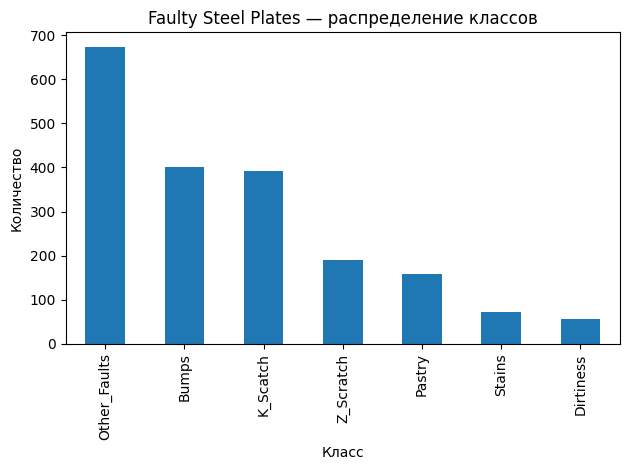

In [4]:


class_counts = y_cls.value_counts()
display(class_counts)

plt.figure()
class_counts.plot(kind="bar")
plt.title("Faulty Steel Plates — распределение классов")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

count    1030.000000
mean       35.817961
std        16.705742
min         2.330000
25%        23.710000
50%        34.445000
75%        46.135000
max        82.600000
Name: concrete_compressive_strength, dtype: float64

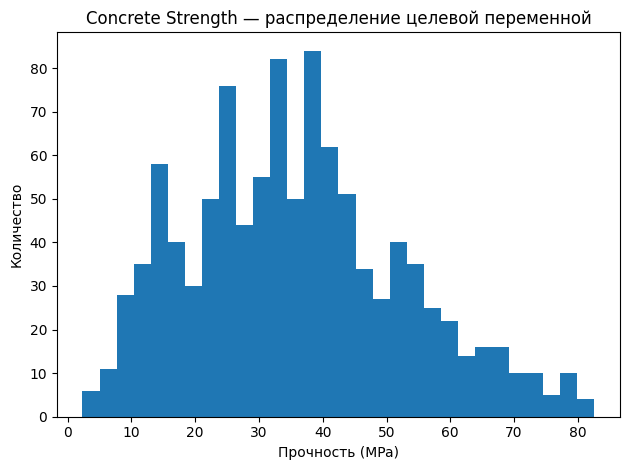

In [5]:


display(y_reg.describe())

plt.figure()
plt.hist(y_reg, bins=30)
plt.title("Concrete Strength — распределение целевой переменной")
plt.xlabel("Прочность (MPa)")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

## 2) Создание бейзлайна и оценка качества

Делаем train/test split и обучаем:
- LogisticRegression для классификации
- LinearRegression для регрессии

В бейзлайне используем простые настройки без подбора гиперпараметров.

In [6]:

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

print("  Classification train/test:", Xc_train.shape, Xc_test.shape)
print("  Regression train/test:    ", Xr_train.shape, Xr_test.shape)

  Classification train/test: (1552, 27) (389, 27)
  Regression train/test:     (824, 8) (206, 8)


In [8]:
logreg_base = LogisticRegression(max_iter=5000)

logreg_base.fit(Xc_train, yc_train)
yc_pred_base = logreg_base.predict(Xc_test)

acc_base = accuracy_score(yc_test, yc_pred_base)
f1m_base = f1_score(yc_test, yc_pred_base, average="macro")

print("Baseline LogisticRegression (classification)")
print("  Accuracy :", round(acc_base, 4))
print("  Macro F1 :", round(f1m_base, 4))

print("\nClassification report:")
print(classification_report(yc_test, yc_pred_base, zero_division=0))


Baseline LogisticRegression (classification)
  Accuracy : 0.5141
  Macro F1 : 0.3339

Classification report:
              precision    recall  f1-score   support

       Bumps       0.45      0.12      0.19        81
   Dirtiness       0.00      0.00      0.00        11
    K_Scatch       0.89      0.74      0.81        78
Other_Faults       0.42      0.90      0.57       135
      Pastry       0.00      0.00      0.00        32
      Stains       0.73      0.79      0.76        14
   Z_Scratch       0.00      0.00      0.00        38

    accuracy                           0.51       389
   macro avg       0.36      0.36      0.33       389
weighted avg       0.45      0.51      0.43       389



C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
linreg_base = LinearRegression()
linreg_base.fit(Xr_train, yr_train)
yr_pred_base = linreg_base.predict(Xr_test)

mae_base = mean_absolute_error(yr_test, yr_pred_base)
rmse_base = np.sqrt(mean_squared_error(yr_test, yr_pred_base)) 
r2_base = r2_score(yr_test, yr_pred_base)

print("Baseline LinearRegression (regression)")
print("  MAE  :", round(mae_base, 4))
print("  RMSE :", round(rmse_base, 4))
print("  R2   :", round(r2_base, 4))

Baseline LinearRegression (regression)
  MAE  : 7.7456
  RMSE : 9.7965
  R2   : 0.6276


## 3) Улучшение бейзлайна (Pipeline + GridSearchCV)

### Гипотезы улучшения
**Классификация:**
1) Масштабирование признаков улучшит Macro F1.  
2) Подбор `C` и `class_weight` даст прирост качества при дисбалансе классов.

**Регрессия:**
1) Полиномиальные признаки (degree 1–3) могут улучшить качество при нелинейной зависимости.  
2) Ridge‑регуляризация нужна, чтобы не переобучаться на расширенных признаках.

In [11]:
pipe_cls = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=8000
    ))
])

param_grid_cls = {
    "logreg__C": [0.01, 0.1, 1.0, 3.0, 10.0],
    "logreg__class_weight": [None, "balanced"],
}

grid_cls = GridSearchCV(
    pipe_cls,
    param_grid=param_grid_cls,
    cv=5,
    n_jobs=-1,
    scoring="f1_macro"
)

grid_cls.fit(Xc_train, yc_train)

print("Best CV params (classification):", grid_cls.best_params_)
print("Best CV macro F1:", round(grid_cls.best_score_, 4))

yc_pred_impr = grid_cls.predict(Xc_test)

acc_impr = accuracy_score(yc_test, yc_pred_impr)
f1m_impr = f1_score(yc_test, yc_pred_impr, average="macro")

print("\nImproved LogisticRegression (classification) on test")
print("  Accuracy :", round(acc_impr, 4))
print("  Macro F1 :", round(f1m_impr, 4))

Best CV params (classification): {'logreg__C': 10.0, 'logreg__class_weight': None}
Best CV macro F1: 0.7273

Improved LogisticRegression (classification) on test
  Accuracy : 0.7326
  Macro F1 : 0.7361


In [12]:
pipe_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("ridge", Ridge())
])

param_grid_reg = {
    "poly__degree": [1, 2, 3],
    "ridge__alpha": [0.1, 1.0, 10.0, 100.0]
}

grid_reg = GridSearchCV(
    pipe_reg,
    param_grid=param_grid_reg,
    cv=5,
    n_jobs=-1,
    scoring="neg_mean_absolute_error"
)

grid_reg.fit(Xr_train, yr_train)

print("Best CV params (regression):", grid_reg.best_params_)
print("Best CV MAE (approx):", round(-grid_reg.best_score_, 4))

yr_pred_impr = grid_reg.predict(Xr_test)

mae_impr = mean_absolute_error(yr_test, yr_pred_impr)
rmse_impr = np.sqrt(mean_squared_error(yr_test, yr_pred_impr))
r2_impr = r2_score(yr_test, yr_pred_impr)

print("\nImproved Linear model (poly + ridge) on test")
print("  MAE  :", round(mae_impr, 4))
print("  RMSE :", round(rmse_impr, 4))
print("  R2   :", round(r2_impr, 4))

Best CV params (regression): {'poly__degree': 3, 'ridge__alpha': 1.0}
Best CV MAE (approx): 4.8151

Improved Linear model (poly + ridge) on test
  MAE  : 4.9297
  RMSE : 7.0935
  R2   : 0.8047


In [13]:
print("Classification")
print("Baseline:  acc =", round(acc_base, 4), "macro_f1 =", round(f1m_base, 4))
print("Improved:  acc =", round(acc_impr, 4), "macro_f1 =", round(f1m_impr, 4))

print("\n=== Regression (test) ===")
print("Baseline:  MAE =", round(mae_base, 4), "RMSE =", round(rmse_base, 4), "R2 =", round(r2_base, 4))
print("Improved:  MAE =", round(mae_impr, 4), "RMSE =", round(rmse_impr, 4), "R2 =", round(r2_impr, 4))

Classification
Baseline:  acc = 0.5141 macro_f1 = 0.3339
Improved:  acc = 0.7326 macro_f1 = 0.7361

=== Regression (test) ===
Baseline:  MAE = 7.7456 RMSE = 9.7965 R2 = 0.6276
Improved:  MAE = 4.9297 RMSE = 7.0935 R2 = 0.8047


## 4) Моя реализация алгоритмов

Ниже реализованы:
- `MySoftmaxRegression` — многоклассовая логистическая регрессия на градиентном спуске.
- `MyRidgeRegressionClosedForm` — линейная через аналитическое решение.

In [14]:
class MySoftmaxRegression:
    def __init__(self, lr=None, n_iter=2000, reg=0.0, class_weight=None, tol=1e-6, verbose=False):
        self.lr = lr
        self.n_iter = n_iter
        self.reg = reg
        self.class_weight = class_weight
        self.tol = tol
        self.verbose = verbose

        self.classes_ = None
        self.W_ = None

    @staticmethod
    def _softmax(Z):
        Z = Z - np.max(Z, axis=1, keepdims=True)
        expZ = np.exp(Z)
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        class_to_idx = {c: i for i, c in enumerate(self.classes_)}
        y_idx = np.array([class_to_idx[v] for v in y], dtype=int)

        n, d = X.shape
        k = len(self.classes_)

        Xb = np.hstack([np.ones((n, 1)), X.astype(float)])

        Y = np.zeros((n, k))
        Y[np.arange(n), y_idx] = 1.0

        if self.class_weight == "balanced":
            counts = np.bincount(y_idx, minlength=k)
            weights = (n / (k * np.maximum(counts, 1))).astype(float)
            sample_w = weights[y_idx]
        else:
            sample_w = np.ones(n, dtype=float)

        self.W_ = np.zeros((d + 1, k), dtype=float)

        if self.lr is None:
            scale = np.mean(np.sum(Xb * Xb, axis=1))
            self.lr = 0.5 / (scale + 1e-9)

        prev_loss = None

        for it in range(self.n_iter):
            logits = Xb @ self.W_
            P = self._softmax(logits)

            eps = 1e-12
            ce = -np.sum(sample_w[:, None] * Y * np.log(P + eps)) / n
            l2 = 0.5 * self.reg * np.sum(self.W_[1:] ** 2)  
            loss = ce + l2

            diff = (P - Y) * sample_w[:, None]
            grad = (Xb.T @ diff) / n
            grad[1:] += self.reg * self.W_[1:]

            self.W_ -= self.lr * grad

            if prev_loss is not None and abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

            if self.verbose and (it % 200 == 0):
                print(f"iter={it:4d} loss={loss:.6f}")

        return self

    def predict(self, X):
        n = X.shape[0]
        Xb = np.hstack([np.ones((n, 1)), X.astype(float)])
        logits = Xb @ self.W_
        P = self._softmax(logits)
        idx = np.argmax(P, axis=1)
        return self.classes_[idx]

In [15]:
class MyRidgeRegressionClosedForm:
    def __init__(self, alpha=0.0):
        self.alpha = float(alpha)
        self.w_ = None

    def fit(self, X, y):
        X = X.astype(float)
        y = y.astype(float).values if isinstance(y, pd.Series) else y.astype(float)

        n = X.shape[0]
        Xb = np.hstack([np.ones((n, 1)), X])  

        d1 = Xb.shape[1]
        I = np.eye(d1)
        I[0, 0] = 0.0  

        A = Xb.T @ Xb + self.alpha * I
        b = Xb.T @ y
        self.w_ = np.linalg.solve(A, b)
        return self

    def predict(self, X):
        X = X.astype(float)
        n = X.shape[0]
        Xb = np.hstack([np.ones((n, 1)), X])
        return Xb @ self.w_

### Обучение моих моделей и сравнение со sklearn‑бейзлайном

In [16]:

my_log_base = MySoftmaxRegression(lr=None, n_iter=2500, reg=0.0, class_weight=None, verbose=False)
my_log_base.fit(Xc_train.values, yc_train.values)
yc_pred_my_base = my_log_base.predict(Xc_test.values)

acc_my_base = accuracy_score(yc_test, yc_pred_my_base)
f1m_my_base = f1_score(yc_test, yc_pred_my_base, average="macro")

print("Моя Logistic - бейзлайн")
print("  Accuracy :", round(acc_my_base, 4))
print("  Macro F1 :", round(f1m_my_base, 4))

Моя Logistic - бейзлайн
  Accuracy : 0.4267
  Macro F1 : 0.1667


In [17]:
my_lin_base = MyRidgeRegressionClosedForm(alpha=0.0)
my_lin_base.fit(Xr_train.values, yr_train)
yr_pred_my_base = my_lin_base.predict(Xr_test.values)

mae_my_base = mean_absolute_error(yr_test, yr_pred_my_base)
rmse_my_base = np.sqrt(mean_squared_error(yr_test, yr_pred_my_base))
r2_my_base = r2_score(yr_test, yr_pred_my_base)

print("Моя линейная регрессия - бейзлайн")
print("  MAE  :", round(mae_my_base, 4))
print("  RMSE :", round(rmse_my_base, 4))
print("  R2   :", round(r2_my_base, 4))

Моя линейная регрессия - бейзлайн
  MAE  : 7.7456
  RMSE : 9.7965
  R2   : 0.6276


In [18]:
print("Classification baseline")
print("sklearn baseline: acc =", round(acc_base, 4), "macro_f1 =", round(f1m_base, 4))
print("custom  baseline: acc =", round(acc_my_base, 4), "macro_f1 =", round(f1m_my_base, 4))

print("\nRegression baseline")
print("sklearn baseline: MAE =", round(mae_base, 4), "RMSE =", round(rmse_base, 4), "R2 =", round(r2_base, 4))
print("custom  baseline: MAE =", round(mae_my_base, 4), "RMSE =", round(rmse_my_base, 4), "R2 =", round(r2_my_base, 4))

Classification baseline
sklearn baseline: acc = 0.5141 macro_f1 = 0.3339
custom  baseline: acc = 0.4267 macro_f1 = 0.1667

Regression baseline
sklearn baseline: MAE = 7.7456 RMSE = 9.7965 R2 = 0.6276
custom  baseline: MAE = 7.7456 RMSE = 9.7965 R2 = 0.6276


### Улучшение моделей

Берём лучшие параметры из GridSearchCV и повторяем улучшения:
- Для классификации: StandardScaler + class_weight + регуляризация
- Для регрессии: StandardScaler + PolynomialFeatures + alpha

In [19]:
best_cls = grid_cls.best_params_
best_reg = grid_reg.best_params_

print("Best (classification):", best_cls)
print("Best (regression):", best_reg)

C_best = best_cls["logreg__C"]
cw_best = best_cls["logreg__class_weight"]

deg_best = best_reg["poly__degree"]
alpha_best = best_reg["ridge__alpha"]

Best (classification): {'logreg__C': 10.0, 'logreg__class_weight': None}
Best (regression): {'poly__degree': 3, 'ridge__alpha': 1.0}


In [20]:
scaler_cls = StandardScaler()
Xc_train_s = scaler_cls.fit_transform(Xc_train)
Xc_test_s = scaler_cls.transform(Xc_test)

reg_best = 1.0 / float(C_best) 
my_log_impr = MySoftmaxRegression(
    lr=None,
    n_iter=3000,
    reg=reg_best,
    class_weight=("balanced" if cw_best == "balanced" else None),
    verbose=False
)

my_log_impr.fit(Xc_train_s, yc_train.values)
yc_pred_my_impr = my_log_impr.predict(Xc_test_s)

acc_my_impr = accuracy_score(yc_test, yc_pred_my_impr)
f1m_my_impr = f1_score(yc_test, yc_pred_my_impr, average="macro")

print("Самописная Logistic (softmax) + улучшения")
print("  Accuracy :", round(acc_my_impr, 4))
print("  Macro F1 :", round(f1m_my_impr, 4))

Самописная Logistic (softmax) + улучшения
  Accuracy : 0.6427
  Macro F1 : 0.4801


In [21]:

scaler_reg = StandardScaler()
Xr_train_s = scaler_reg.fit_transform(Xr_train)
Xr_test_s = scaler_reg.transform(Xr_test)

poly = PolynomialFeatures(degree=int(deg_best), include_bias=False)
Xr_train_sp = poly.fit_transform(Xr_train_s)
Xr_test_sp = poly.transform(Xr_test_s)

my_ridge_impr = MyRidgeRegressionClosedForm(alpha=float(alpha_best))
my_ridge_impr.fit(Xr_train_sp, yr_train)
yr_pred_my_impr = my_ridge_impr.predict(Xr_test_sp)

mae_my_impr = mean_absolute_error(yr_test, yr_pred_my_impr)
rmse_my_impr = np.sqrt(mean_squared_error(yr_test, yr_pred_my_impr))
r2_my_impr = r2_score(yr_test, yr_pred_my_impr)

print("poly + ridge + улучшения")
print("  MAE  :", round(mae_my_impr, 4))
print("  RMSE :", round(rmse_my_impr, 4))
print("  R2   :", round(r2_my_impr, 4))

poly + ridge + улучшения
  MAE  : 4.9297
  RMSE : 7.0935
  R2   : 0.8047


In [22]:

print("Сравнение")
print("sklearn improved: acc =", round(acc_impr, 4), "macro_f1 =", round(f1m_impr, 4))
print("custom  improved: acc =", round(acc_my_impr, 4), "macro_f1 =", round(f1m_my_impr, 4))

print("\nИтог регрессия")
print("sklearn improved: MAE =", round(mae_impr, 4), "RMSE =", round(rmse_impr, 4), "R2 =", round(r2_impr, 4))
print("custom  improved: MAE =", round(mae_my_impr, 4), "RMSE =", round(rmse_my_impr, 4), "R2 =", round(r2_my_impr, 4))

Сравнение
sklearn improved: acc = 0.7326 macro_f1 = 0.7361
custom  improved: acc = 0.6427 macro_f1 = 0.4801

Итог регрессия
sklearn improved: MAE = 4.9297 RMSE = 7.0935 R2 = 0.8047
custom  improved: MAE = 4.9297 RMSE = 7.0935 R2 = 0.8047


## Вывод

В лабораторной работе были исследованы две реальные задачи на данных из Kaggle: классификация дефектов стальных листов (1941 объект, 27 признаков, 7 классов) и регрессия прочности бетона (1030 объектов, 8 признаков). Пропусков в обоих наборах данных не обнаружено. Для классификации по распределению классов видно, что данные несбалансированы (есть редкие классы вроде Dirtiness и Stains), поэтому дополнительно использовалась метрика Macro F1, которая честнее показывает качество на редких классах, чем одна только Accuracy.

1) Бейзлайн-модели (sklearn)

Логистическая регрессия (классификация): Accuracy = 0.527, Macro F1 = 0.3407.
Несмотря на приемлемую accuracy, macro F1 низкий: модель практически не предсказывает часть классов (по отчёту видно нулевые значения для нескольких меток). Это связано с дисбалансом и тем, что линейная модель без хорошей настройки/предобработки может “тянуться” к доминирующему классу.

Линейная регрессия (регрессия): MAE = 7.7456, RMSE = 9.7965, R2 = 0.6276.
Бейзлайн объясняет данные умеренно хорошо, но качество ограничено тем, что зависимость прочности от факторов явно нелинейная.

Также во время обучения логистической регрессии появлялись предупреждения о сходимости/параметре multi_class — это указывает, что модель чувствительна к масштабам признаков и настройкам, что логично для оптимизации.

2) Улучшенный бейзлайн (Pipeline + GridSearchCV)

В улучшении были применены стандартные техники: предобработка и подбор гиперпараметров на кросс-валидации.

Классификация (LogReg): лучшими стали параметры C = 10.0, class_weight = None.
На тесте качество выросло до Accuracy = 0.7326, Macro F1 = 0.7361.
Рост очень существенный: Macro F1 0.3407 → 0.7361, то есть модель стала заметно лучше различать все классы, включая менее представленные.

Регрессия (poly + ridge): лучшими стали degree = 3, alpha = 1.0.
На тесте: MAE = 4.9297, RMSE = 7.0935, R2 = 0.8047.
Это подтверждает гипотезу о нелинейности: добавление полиномиальных признаков дало резкий прирост, а Ridge помог стабилизировать модель и снизить переобучение.

Итого улучшения дали:

Классификация: Accuracy 0.527 → 0.7326, Macro F1 0.3407 → 0.7361

Регрессия: MAE 7.7456 → 4.9297, R2 0.6276 → 0.8047

3) Самописные модели и сравнение со sklearn

Самописная линейная регрессия полностью повторила результат sklearn-бейзлайна и улучшенного варианта (после добавления poly+ridge): метрики совпали (MAE/RMSE/R2 одинаковые). Это означает, что реализация корректна и соответствует математической модели.

Самописная логистическая регрессия (softmax) в базовом виде дала хуже, чем sklearn (Accuracy 0.4267, Macro F1 0.1667), а после улучшений поднялась до Accuracy 0.6427, Macro F1 0.4801, но всё равно не достигла уровня sklearn (Macro F1 0.7361).
Такой разрыв обычно объясняется тем, что в самописной версии не хватает некоторых “инженерных” деталей, которые есть в sklearn: более устойчивой оптимизации (LBFGS/SAGA), тонкой настройки регуляризации, критериев остановки, численной стабилизации softmax/log-loss и т.п. Тем не менее улучшения заметно повысили качество, значит направление (масштабирование/настройка) выбрано верно.

Итог

Для классификации логистическая регрессия без настройки показывает ограниченное качество из-за дисбаланса и особенностей обучения, но после подбора параметров качество выросло очень сильно, особенно по Macro F1.

Для регрессии простая линейная модель проигрывает, но добавление полиномиальных признаков и Ridge радикально улучшает результат, подтверждая нелинейную природу зависимости прочности бетона от факторов состава.

Самописная реализация регрессии совпала со sklearn, а самописная softmax-логистика уступила sklearn, что показывает важность устойчивых алгоритмов оптимизации и регуляризации в практических реализациях.